# Linear FEM Laplacian VS Heat Kernel Graph Laplacian

__author: Martino Milani__

__e-mail: martino.milani@alumni.epfl.ch__

This notebook shows the behaviour of the __Heat Kernel Graph Laplacian__ (__HKGL__, built following [1])
and the __Linear FEM Laplacian__ on the sphere. Two sampling schemes are taken into consideration: 
the equiangular sampling [2] and HEALPix [3]. It is shown that the FEM Laplacian has spectral properties (namely, eigenvalues and eigenvectors) much closer to the ones of the continuous Laplacian, compared to the HKGL.

[1] Convergence of Laplacin Eigenmaps, Belkin and Nyiogi, 2008

[2] Computing Fourier Transforms and Convolutions on the 2-Sphere, Driscoll and Healy, 1994

[3] The HEALPIx primer, Gorski et al., 2010

[4] DeepSphere, Perraudin et al, 2019

### HOW TO RUN THIS NOTEBOOK:

The problem is to run FEniCS in a Jupyter notebook. Setting the correct paths is painful, so it's better to run juyter notebook in the following Docker container already set. 

Once installed Docker, install the FEniCS project Docker script with the following command:

> curl -s https://get.fenicsproject.org | bash

then, run the following commands (not sure)

> fenicsproject create myproject

> fenicsproject notebook myproject

> fenicsproject start myproject

to start the juyter notebook in the Docker container. Copy paste the http printed on the console in the browser to access the notebook.

Since the Docker image is provided with only fenics installed, in another terminal session run

> docker exec -it myproject /bin/bash

to ssh into the docker container, in order to pip install all the packages (meshio, pygsp) needed for this notebook. Once the needed packages are installed, the jupyter notebook should run smoothly.

In [2]:
"""author: Martino Milani
email: martino.milani@alumni.epfl.ch

This notebook shows the behaviour of the Heat Kernel Graph Laplacian (HKGL, built following [1])
and the Linear FEM Laplacian on the sphere. Two sampling schemes are taken into consideration: 
the equiangular sampling [2] and HEALPix [3].

It is shown that the FEM Laplacian has spectral properties (namely, eigenvalues and eigenvectors)
much closer to the ones of the continuous Laplacian, compared to the HKGL"""

%load_ext autoreload
%autoreload 2
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
from scipy.spatial import ConvexHull
import meshio
import scipy
from pygsp.graphs import Graph
from deepsphere import utils
import pyshtools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0) Construction of the HKGL for HEALPIX and the Equiangular sampling

We implement the construction of these two sampling schemes in two classes: 
* `FullEquiangular()`
* `FullHEALPix()`

Example of usage of the two classes:

`sphere = FullHEALPix(nside=16)
sphere.plot()
sphere.plot_spectrum_analysis()`


`sphere = FullEquiangular(nside=16)
sphere.plot()
sphere.plot_spectrum_analysis()`

In [3]:
class MyGraph(Graph):
    """Base class for the following two classes: FullEquiangular, FullHEALPix.
    It provides the implementation of the construction of the mesh given the matrix self.coords.
    The matrix self.coords has shape [npix, 3] and it contains the coordinates of each one of the vertices
    of the graph.
    
    It derives from pygsp.graphs.Graph, that implements the following useful commands:
        >>>> g = Graph(adjacency = W)
        >>>> Graph.L   # the combinatorial graph Laplacian $L=D-W$
        >>>> Graph.U   # the graph Fourier basis $L=U^{T} \Lambda U$ 
        >>>> Graph.e   # diag(\Lambda), i.e., the eigenvalues of g.L
    """
    def __init__(self, adjacency, coords):
        super(MyGraph, self).__init__(adjacency, coords=coords)
        
    def _init_vtk(self):
        tri = ConvexHull(self.coords)
        self.simplices = tri.simplices
        
    def save_mesh(self, file="mesh.xml"):
        self._init_vtk()
        cells = {"triangle": self.simplices}
        meshio.write_points_cells(
            file,
            self.coords,
            cells)
          
    def plot_spectral_content(self, cl, lmax, title, param):
        """Helper fumnction to plot the spectral content of the graph Laplacian.
        Used in the method plot_spectrum_analysis of the two child classes."""

        spectral_content = np.empty((lmax+1, lmax+1))
        start = 0
        for ell in range(lmax+1):
            end = start + (2 * ell + 1)
            spectral_content[ell] = np.sum(cl[start:end,:], axis=0)/np.sum(cl[start:end,:])
            start = end

        # --------------- plotting the alignment of the eigenspaces ---------------------
        fig1, ax = plt.subplots()
        fig2, ax2 = plt.subplots()

        sc = spectral_content
        sc = sc / sc[0, 0]
        im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
        title = ('Alignment of eigenspaces, '+title+'={}').format(param)
        ax.set_title(title)
        ax.set_xlabel("Continuous eigenspaces")
        ax.set_ylabel("Discrete eigenspaces")
        
        energy_in = np.diag(sc)
        ax2.plot(energy_in, 'o')
        ax2.set_xlabel("Degree")
        ax2.set_ylabel("Percentage of alignment")
        ax2.set_title(title)

In [4]:
def to_array(f, bw):
    """Helper function to work with FullEquiangular.
    It transforms a signal on the equiangular sampling from 1D vector to a 2D grid necessary
    to initiate a pyshtools.SHGrid object, that lets us compute its SHT (Spherical Harmonic Transform)
    and lets us plot it nicely."""
    
    height, width = 2*bw, 2*bw
    array = np.zeros((height, width))  # shape=(longitude, latitude)
    f = np.append([f[0]]*(2*bw-1), f)  # correct! the first line is the North pole repeated 2bw times
    # now we need to undo the meshgrid
    assert f.size == array.size
    for n, fx in enumerate(f):
        j = n%width
        i = n//width
        array[i, j] = fx
    return array

In [5]:
class FullEquiangular(MyGraph):
    """Implements the full graph on the equiangular sampling given a bandwidth bw.
    Example of usage:
    
    >>>> sphere = FullEquiangular(bw=16)
    >>>> sphere.plot()  # inherited from pygsp.graphs.Graph, also pretty useful method
    >>>> sphere.plot_spectrum_analysis()  
    """
    
    sigmas = {1:1,
              2:0.3,
              4: 0.175, 
              8: 0.0525,
              16: 0.015,
              32: 0.004}
    
    def make_coords(self, bw):
        """Equiangular sampling.
        
        This function creates the (npix X 3) matrix that contains all the coordinates
        of all the vertices of the graph."""
        alpha = np.arange(2 * bw) * np.pi / bw
        beta = np.arange(2 * bw) * np.pi / (2. * bw)
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        coords = coords[2*bw-1:]
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.z = coords[:,2]
        self.npix = np.alen(coords)
        return coords

    
    def __init__(self, bw=8):
        self.bw = bw
        self.npix = 2*bw*(2*bw-1)+1
        coords = self.make_coords(bw)
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        W = np.exp(-distances_squared/self.sigmas[bw])
        W = W-np.diag(np.diag(W))
        super(FullEquiangular, self).__init__(W, coords=coords)
        self._init_vtk()
    
    def power_spectrum_analysis(self, harmonics=None):
        """It uses the sampling theorem of Driscoll and Healy (1994) to compute a perfect SHT of the harmonics.
        Such SHT is implemented in the following function: pyshtools.SHGrid.expand().
        
        If harmonics==None, it plots the power spectrum analysis as explained in [4] of the eigenvectors
        of the graph laplacian. If harmonics is a matrix, it plots the power spectrum analysis as explained in [4]
        of the columns of such matrix"""
        
        # --------------- initialization ---------------
        bw = self.bw
        lmax = bw-1
        if harmonics is None:
            self.compute_fourier_basis()
            harmonics = self.U
        n_harmonics = harmonics.shape[1]
            
        # ------------ calculating alignment between eigenspaces  ----------------
        cl = np.empty((n_harmonics, lmax+1))
        for i in range(n_harmonics):
            eigenvector = harmonics[:, i]
            eig_array = to_array(eigenvector, bw)
            g = pyshtools.SHGrid.from_array(eig_array)
            clm = g.expand(normalization='unnorm')
            cl[i] = clm.spectrum()
        
        self.plot_spectral_content(cl, lmax, "bandwidth", bw)
        



In [6]:
class FullHEALPix(MyGraph):
    """Example of usage:
    
    >>>> sphere = FullHEALPix(nside=16)
    >>>> sphere.plot()  # inherited from pygsp.graphs.Graph, also pretty useful method
    >>>> sphere.plot_spectrum_analysis()"""  
    sigmas = {4:0.5,
              8:0.05,
              16: 0.1, 
              32: 0.03,
              64: 0.01}
    
    def make_coords(self):
        """HEALPix sampling.
        
        This function creates the (npix X 3) matrix that contains all the coordinates
        of all the vertices of the graph."""
        indexes = range(self.nside**2 * 12)
        # Get the coordinates.
        x, y, z = hp.pix2vec(self.nside, indexes, nest=True)  # NESTED ordered
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords)
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.z = coords[:,2]
        return coords

    
    def __init__(self, nside=8, std=None):
        self.nside = nside
        self.npix = 12*nside**2
        coords = self.make_coords()
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        if isinstance(std, float) or isinstance(std, int):
            W = np.exp(-distances_squared / std)
        else:
            W = np.exp(-distances_squared / self.sigmas[nside])
        W = W-np.diag(np.diag(W))
        super(FullHEALPix, self).__init__(W, coords=coords)
        self._init_vtk()
    
    def power_spectrum_analysis(self, harmonics=None):
        """If harmonics==None, it plots the power spectrum analysis as explained in [4]
        of the eigenvectors of the graph laplacian. If harmonics is a matrix, it plots 
        the power spectrum analysis as explained in [4] of the columns of such matrix
        
        It has to differ from the implementation of FullEquiangular since the way to
        calculate the SHT is different. Here we use healpy.sphtfunc.anafast.
        Look carefully at the documentation of anafast to comprehend its limits."""
        
        nside = self.nside
        lmax = 3 * nside - 1
        if harmonics is None:
            harmonics = utils.compute_spherical_harmonics(nside, lmax=lmax)
        n_harmonics = harmonics.shape[1]

        cl = np.empty((n_harmonics, lmax+1))
        for i in range(n_harmonics):
            harmonic = hp.reorder(harmonics[:, i], n2r=True)
            cl[i] = hp.sphtfunc.anafast(harmonic, lmax=lmax, iter=8)
        
        self.plot_spectral_content(cl, lmax, "nside", nside)

In [7]:
from scipy.sparse import csr_matrix
    
class FEM_HEALPix(MyGraph):
    """disconneted graph, useful to avoid computing a full graph for big nsides.
    Use this class when interested to compute the FEM triangulation.
    
    Example of usage:
    
    >>>> sphere = FEM_HEALPix(nside=16)
    >>>> sphere.save_mesh("mesh.xml")"""
    
    sigmas = {4:0.5,
              8:0.05,
              16: 0.1, 
              32: 0.03,
              64: 0.01}
    
    def make_coords(self):
        """HEALPix sampling.
        
        This function creates the (npix X 3) matrix that contains all the coordinates
        of all the vertices of the graph."""
        indexes = range(self.nside**2 * 12)
        # Get the coordinates.
        x, y, z = hp.pix2vec(self.nside, indexes, nest=True)  # NESTED ordered
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords)
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.z = coords[:,2]
        return coords

    
    def __init__(self, nside=8, std=None):
        self.nside = nside
        self.npix = 12*nside**2
        coords = self.make_coords()

        W = csr_matrix((self.npix, self.npix), dtype=np.int8)
        super(FEM_HEALPix, self).__init__(W, coords=coords)
        self._init_vtk()

# 1) Analysis of the goodness of the HKGL for the two sampling schemes

We analyse how much the eigenvectors of the graph Laplacian are aligned with the continuous Spherical Harmonics through the computation of the Discrete Spherical Harmonic Transform, as explained in [4]. It is visible that, as expected, the HEALPix sampling has a much better behaviour than the equiangular sampling scheme, most probably due to its uniformity.

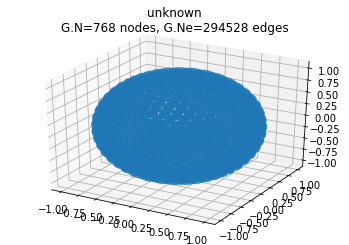

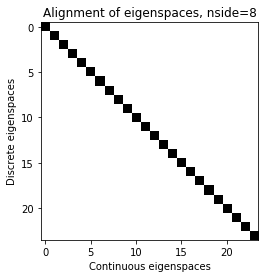

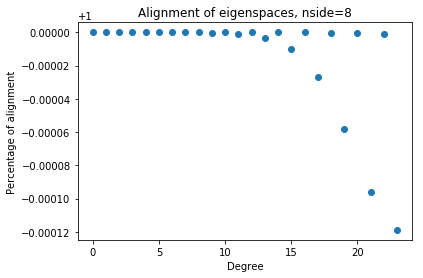

In [14]:
sphere = FullHEALPix(nside=8)
sphere.plot()
sphere.power_spectrum_analysis()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


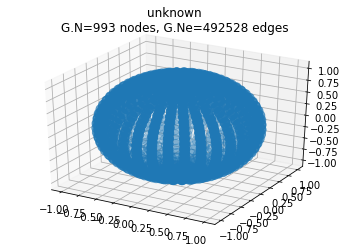

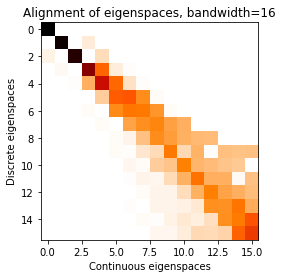

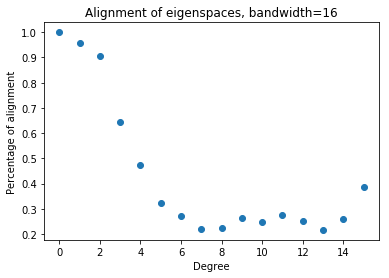

In [9]:
sphere = FullEquiangular(16)
sphere.plot()
sphere.power_spectrum_analysis()

# 2) Finite Element Method (on the Equiangular sampling only)


We now want to repeat the same spectral analysis on the eigenvectors of the Linear FEM Laplacian. We thus need to 

* assembly the stiffness and mass matrices A, B
* compute the eigenvectors of B^{-1}A
* as already done in section (1), analyse the alignment of the eigenvectors of B^{-1}A


### 2.1) assembling of the stiffness and mass matrix

In [10]:
#bw = 16
#sphere = FullEquiangular(bw)
nside = 128
sphere = FEM_HEALPix(nside)

In [11]:
from __future__ import print_function
from scipy.sparse import csr_matrix
from dolfin import *


# Test for PETSc and SLEPc
if not has_linear_algebra_backend("PETSc"):
    print("DOLFIN has not been configured with PETSc. Exiting.")
    exit()

if not has_slepc():
    print("DOLFIN has not been configured with SLEPc. Exiting.")
    exit()

spectral_content = dict()

# Define mesh and function space for the FEM method
sphere.save_mesh("mesh.xml")
mesh = Mesh("mesh.xml")  # TODO: understand how to pass a mesh to dolfin without saving it to the HDD
global_normal = Expression(("x[0]", "x[1]", "x[2]"), degree=1)
mesh.init_cell_orientations(global_normal)
V = FunctionSpace(mesh, "Lagrange", 1)

# Define basis and bilinear form
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx  # lhs of the weak form of the differential problem
b = dot(u, v)*dx              # rhs of the weak form of the differential problem
# Assemble stiffness and mass matrix
A_PETSC = PETScMatrix()
B_PETSC = PETScMatrix()
assemble(a, tensor=A_PETSC)
assemble(b, tensor=B_PETSC)

# just changing format of the matrices to handle them with numpy
A_mat = as_backend_type(A_PETSC).mat()
stiffness = csr_matrix(A_mat.getValuesCSR()[::-1], shape=A_mat.size)
B_mat = as_backend_type(B_PETSC).mat()
mass = csr_matrix(B_mat.getValuesCSR()[::-1], shape=B_mat.size)

### Technical step: reordering of the matrices A, B
This is necessary because the matrices `stiffness`, `mass` __have been reordered by FEniCS (to optimize typical FEM operations that we wont use)__: It is imperative that they maintain the same order of the `coords` matrix. 
We thus have to make the matrices A, B correspond to the original ordering.

In [12]:
reordering_mask = np.flip(vertex_to_dof_map(V))
# ---------------------------------------------------------

In [17]:
# here we reorder the matrices produces by FEniCS in order to have the same order of sphere.coords
stiffness = stiffness[reordering_mask]
mass = mass[reordering_mask]
stiffness = stiffness[:, reordering_mask]
mass = mass[:, reordering_mask]

scipy.sparse.save_npz('deepsphere/matrices/{}_stiffness'.format(sphere.nside), stiffness)
scipy.sparse.save_npz('deepsphere/matrices/{}_mass'.format(sphere.nside), mass)

### 2.2)  Compute the eigenvectors of B^{-1}A

In [ ]:
N = sphere.npix  # how many eigenvectors do I calculate

# Create eigensolver
eigensolver = SLEPcEigenSolver(A_PETSC, B_PETSC)
eigensolver.parameters['spectrum'] = 'target real'
eigensolver.parameters['tolerance'] = 1.e-4
eigensolver.parameters['maximum_iterations'] = 10000

# Compute all eigenvalues of A x = \lambda x
print("Computing eigenvalues. This can take a minute.")
eigensolver.solve(N)

eig_vectors = np.ndarray((sphere.npix, N), dtype='float')
eig_values = np.ndarray(N, dtype='float')
for i in range(N):
    # Extract largest (first) eigenpair
    r, c, rx, cx = eigensolver.get_eigenpair(i)

    # Initialize function and assign eigenvector
    u = Function(V)
    u.vector()[:] = rx
    eig_vectors[:, i] = u.compute_vertex_values()  # through this function we don't need the reordering_masks!
    eig_values[i] = r

### 2.3)  analyse the alignment of the eigenvectors of B^{-1}A

In [ ]:
sphere.power_spectrum_analysis(eig_vectors)

# 3) Deeper comparison between Linear FEM Laplacian and HKGL (on the Equiangular sampling only)

### 3.1) Comparing eigenvalues

In [ ]:
plt.plot(eig_values[:50], 'bo')
plt.title("Eigenvalues of the FEM Linear Laplacian on the equiangular sampling")

In [ ]:
plt.plot(sphere.e[:50], 'bo')
plt.title("Eigenvalues of the HKGL on the equiangular sampling")

### 3.2) Comparing eigenvectors

In [ ]:
lmax = bw-1
n_harmonics = eig_vectors.shape[1]
cl = np.empty((n_harmonics, lmax+1))
for i in [1,5,10,17,26,37]:
    eigenvector = eig_vectors[:, i]
    eig_array = to_array(eigenvector, bw)
    g = pyshtools.SHGrid.from_array(eig_array)
    g.plot()
    plt.show()

In [ ]:
eig_vectors = sphere.U
lmax = bw-1
n_harmonics = eig_vectors.shape[1]
cl = np.empty((n_harmonics, lmax+1))
for i in [1,5,10,17,26,37]:
    eigenvector = eig_vectors[:, i]
    eig_array = to_array(eigenvector, bw)
    g = pyshtools.SHGrid.from_array(eig_array)
    g.plot()
    plt.show()